<a href="https://colab.research.google.com/github/shubhi/MSAI-437-HW2-Autoencoders/blob/main/HW2_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ASSIGNMENT: HW2 AUTOENCODERS - CODE**

## **Packages**

In [192]:
!pip install torchviz

In [193]:
!pip install datasets

In [194]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


## **Data Processing**

Dataset: *HuggingFace - Emoji Dataset*

Link: [https://huggingface.co/datasets/valhalla/emoji-dataset](https://huggingface.co/datasets/valhalla/emoji-dataset)



### **Load Data from HuggingFace**

In [195]:
from datasets import load_dataset_builder
ds_builder = load_dataset_builder("valhalla/emoji-dataset")

In [196]:
ds_builder.info.description
ds_builder.info.features

{'image': Image(decode=True, id=None), 'text': Value(dtype='string', id=None)}

In [197]:
from datasets import get_dataset_split_names
get_dataset_split_names("valhalla/emoji-dataset")

['train']

In [198]:
from datasets import load_dataset

dataset = load_dataset("valhalla/emoji-dataset")

In [199]:
dataset['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'text': 'grinning face'}

### **Create subset of data based on categories with expressions/facial features**

In [200]:
expression_categories = ["face", "vampire", "elf", "mage", "hero", "villain", "evil monkey", "zombie", "haircut", "juggling"]

subset = dataset['train'].filter(lambda example: any(category in example['text'] for category in expression_categories))

Number of images related to expression categories: 342
Subset example: {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F0C93104730>, 'text': 'cat face with tears of joy'}


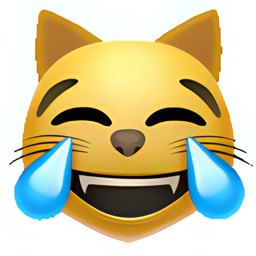

In [201]:
import io
from IPython.display import display
print("Number of images related to expression categories:", len(subset))
print("Subset example:", subset[25])
image = subset[25]['image']
display(image)

### **Add class label "class_fiction"**

In [202]:
def assign_class_label(example):
    fictional_descriptions = ["vampire", "elf", "mage", "hero", "villain", "zombie"]
    if any(description in example['text'] for description in fictional_descriptions):
        return {'text': example['text'], 'label': 1, 'image': example['image']}
    else:
        return {'text': example['text'], 'label': 0, 'image': example['image']}

In [203]:
labeled_subset = [assign_class_label(example) for example in subset]

In [204]:
print("Subset example:", labeled_subset[25])
print("Subset example:", labeled_subset[100])

Subset example: {'text': 'cat face with tears of joy', 'label': 0, 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F0C93106D40>}
Subset example: {'text': 'man elf dark skin tone', 'label': 1, 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F0C931067A0>}


### **Set random seed at 42**

In [205]:
import random
import numpy as np
import torch

# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

### **Split Data 60/20/20**

In [206]:
from torch.utils.data import random_split

In [207]:
total_size = len(subset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

In [208]:
train, val, test = random_split(labeled_subset, [train_size, val_size, test_size])

In [209]:
print("Split Size:\n")
print("Train dataset size:", len(train))
print("Validation dataset size:", len(val))
print("Test dataset size:", len(test))

Split Size:

Train dataset size: 205
Validation dataset size: 68
Test dataset size: 69


### **Augment to 600/200/200**

In [210]:
from torch.utils.data import DataLoader
from torchvision import transforms

In [211]:
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Random rotation up to 10 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with a probability of 0.5
    transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip with a probability of 0.5
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),  # Random resized crop
    transforms.RandomApply([transforms.RandomAffine(degrees=5, translate=(0.1, 0.1))], p=0.5),  # Random affine transformation
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),  # Random Gaussian blur
])

In [214]:
def augment_dataset(dataset, target_size):
    augmented_dataset = []
    while len(augmented_dataset) < target_size:
        for example in dataset:
            augmented_image = augmentation_transforms(example['image'])
            augmented_example = {'text': example['text'], 'label': example['label'], 'image': augmented_image}
            augmented_dataset.append(augmented_example)
            if len(augmented_dataset) >= target_size:
                break
    return augmented_dataset

In [215]:
# Augment the train, validation, and test sets
train_aug = augment_dataset(train, 600)
val_aug = augment_dataset(val, 200)
test_aug = augment_dataset(test, 200)

In [218]:
print("Augmented train dataset size:", len(train_aug))
print("Augmented validation dataset size:", len(val_aug))
print("Augmented test dataset size:", len(test_aug))

Augmented train dataset size: 600
Augmented validation dataset size: 200
Augmented test dataset size: 200


### **Resize to 64x64**

In [219]:
resize_transform = transforms.Resize((64, 64))

In [220]:
def resize_dataset(dataset):
    resized_dataset = []
    for example in dataset:
        resized_image = resize_transform(example['image'])
        resized_example = {'text': example['text'], 'label': example['label'], 'image': resized_image}
        resized_dataset.append(resized_example)
    return resized_dataset

In [221]:
train_aug_resized = resize_dataset(train_aug)
val_aug_resized = resize_dataset(val_aug)
test_aug_resized = resize_dataset(test_aug)

## **End of data processing - final datasets**

In [223]:
train_set = train_aug_resized
val_set = val_aug_resized
test_set = test_aug_resized

## **Autoencoder**

### **Architecture**

In [224]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder_32(nn.Module):
    def __init__(self):
        super(Autoencoder_32, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Autoencoder_64(nn.Module):
    def __init__(self):
        super(Autoencoder_64, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Autoencoder_128(nn.Module):
    def __init__(self):
        super(Autoencoder_128, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### **Training**

In [225]:
def train_autoencoder(train_set, val_set, latent_size, num_epochs=10, lr=0.001, weight_decay=1e-5):

    if latent_size == 32:
      model = Autoencoder_32()
    elif latent_size == 64:
      model = Autoencoder_64()
    elif latent_size == 128:
      model = Autoencoder_128()
    else:
      return

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for t in train_set:
            optimizer.zero_grad()
            images = transforms.ToTensor()(t['image'])
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
        epoch_train_loss = running_train_loss / len(train_set)
        train_losses.append(epoch_train_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for v in val_set:
                images = transforms.ToTensor()(v['image'])
                outputs = model(images)
                loss = criterion(outputs, images)
                running_val_loss += loss.item() * images.size(0)
        epoch_val_loss = running_val_loss / len(val_set)
        val_losses.append(epoch_val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    return model, train_losses, val_losses

In [234]:
# Hyperparameters
ae_latent_sizes = [32, 64, 128]  # Define latent sizes to be tuned
ae_num_epochs=35
ae_lr=0.001
ae_weight_decay=1e-5

Training model with latent size: 32
Epoch [1/35], Train Loss: 0.1108, Val Loss: 0.0478
Epoch [2/35], Train Loss: 0.0355, Val Loss: 0.0294
Epoch [3/35], Train Loss: 0.0237, Val Loss: 0.0209
Epoch [4/35], Train Loss: 0.0203, Val Loss: 0.0186
Epoch [5/35], Train Loss: 0.0184, Val Loss: 0.0169
Epoch [6/35], Train Loss: 0.0168, Val Loss: 0.0154
Epoch [7/35], Train Loss: 0.0153, Val Loss: 0.0140
Epoch [8/35], Train Loss: 0.0136, Val Loss: 0.0125
Epoch [9/35], Train Loss: 0.0124, Val Loss: 0.0116
Epoch [10/35], Train Loss: 0.0116, Val Loss: 0.0110
Epoch [11/35], Train Loss: 0.0110, Val Loss: 0.0105
Epoch [12/35], Train Loss: 0.0105, Val Loss: 0.0105
Epoch [13/35], Train Loss: 0.0101, Val Loss: 0.0099
Epoch [14/35], Train Loss: 0.0098, Val Loss: 0.0096
Epoch [15/35], Train Loss: 0.0095, Val Loss: 0.0094
Epoch [16/35], Train Loss: 0.0092, Val Loss: 0.0092
Epoch [17/35], Train Loss: 0.0089, Val Loss: 0.0089
Epoch [18/35], Train Loss: 0.0087, Val Loss: 0.0087
Epoch [19/35], Train Loss: 0.0084, Va

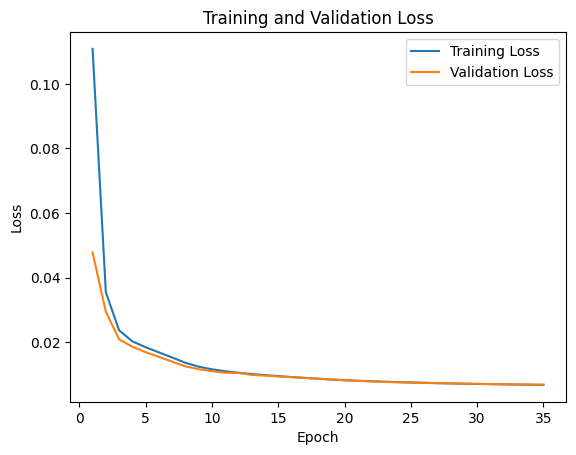

Training model with latent size: 64
Epoch [1/35], Train Loss: 0.1545, Val Loss: 0.0788
Epoch [2/35], Train Loss: 0.0627, Val Loss: 0.0601
Epoch [3/35], Train Loss: 0.0500, Val Loss: 0.0498
Epoch [4/35], Train Loss: 0.0399, Val Loss: 0.0493
Epoch [5/35], Train Loss: 0.0343, Val Loss: 0.0386
Epoch [6/35], Train Loss: 0.0310, Val Loss: 0.0332
Epoch [7/35], Train Loss: 0.0289, Val Loss: 0.0324
Epoch [8/35], Train Loss: 0.0236, Val Loss: 0.0240
Epoch [9/35], Train Loss: 0.0202, Val Loss: 0.0221
Epoch [10/35], Train Loss: 0.0184, Val Loss: 0.0198
Epoch [11/35], Train Loss: 0.0176, Val Loss: 0.0202
Epoch [12/35], Train Loss: 0.0166, Val Loss: 0.0181
Epoch [13/35], Train Loss: 0.0158, Val Loss: 0.0169
Epoch [14/35], Train Loss: 0.0147, Val Loss: 0.0144
Epoch [15/35], Train Loss: 0.0145, Val Loss: 0.0142
Epoch [16/35], Train Loss: 0.0139, Val Loss: 0.0134
Epoch [17/35], Train Loss: 0.0133, Val Loss: 0.0130
Epoch [18/35], Train Loss: 0.0132, Val Loss: 0.0124
Epoch [19/35], Train Loss: 0.0126, Va

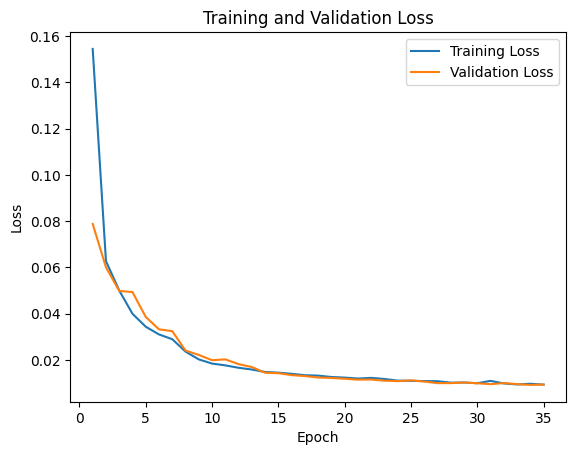

Training model with latent size: 128
Epoch [1/35], Train Loss: 0.2054, Val Loss: 0.1425
Epoch [2/35], Train Loss: 0.1131, Val Loss: 0.0953
Epoch [3/35], Train Loss: 0.0795, Val Loss: 0.0853
Epoch [4/35], Train Loss: 0.0675, Val Loss: 0.0719
Epoch [5/35], Train Loss: 0.0587, Val Loss: 0.0646
Epoch [6/35], Train Loss: 0.0540, Val Loss: 0.0617
Epoch [7/35], Train Loss: 0.0511, Val Loss: 0.0581
Epoch [8/35], Train Loss: 0.0481, Val Loss: 0.0592
Epoch [9/35], Train Loss: 0.0467, Val Loss: 0.0573
Epoch [10/35], Train Loss: 0.0484, Val Loss: 0.0502
Epoch [11/35], Train Loss: 0.0433, Val Loss: 0.0558
Epoch [12/35], Train Loss: 0.0421, Val Loss: 0.0621
Epoch [13/35], Train Loss: 0.0418, Val Loss: 0.0469
Epoch [14/35], Train Loss: 0.0407, Val Loss: 0.0437
Epoch [15/35], Train Loss: 0.0372, Val Loss: 0.0404
Epoch [16/35], Train Loss: 0.0357, Val Loss: 0.0388
Epoch [17/35], Train Loss: 0.0341, Val Loss: 0.0368
Epoch [18/35], Train Loss: 0.0330, Val Loss: 0.0347
Epoch [19/35], Train Loss: 0.0323, V

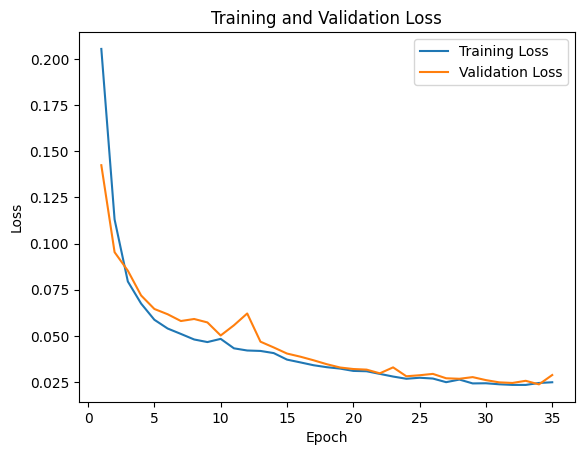

Best latent size: 32, Best validation loss: 0.0068


In [235]:
import matplotlib.pyplot as plt
best_val_loss = float('inf')
best_ae_latent_size = None
ae_model = None
ae_train_losses = []
ae_val_losses = []
for latent_size in ae_latent_sizes:
    print(f'Training model with latent size: {latent_size}')
    model, train_losses, val_losses = train_autoencoder(train_set, val_set, latent_size, ae_num_epochs, ae_lr, ae_weight_decay)
    plt.plot(range(1, ae_num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, ae_num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        ae_model = model
        best_ae_latent_size = latent_size
        ae_train_losses = train_losses
        ae_val_losses = val_losses

print(f'Best latent size: {best_ae_latent_size}, Best validation loss: {best_val_loss:.4f}')


### ***End of Training: Save Best Model and Latent Represenatations***

In [240]:
def save_model_weights(model, filepath):
    torch.save(model.state_dict(), filepath)

def save_latent_representations(model, dataset, filepath):
    model.eval()
    latent_reps = []
    with torch.no_grad():
        for t in dataset:
            images = transforms.ToTensor()(t['image'])
            latent_rep = model.encoder(images.unsqueeze(0))
            latent_reps.append(latent_rep.squeeze().numpy())
    np.save(filepath, np.array(latent_reps))

save_model_weights(ae_model, 'autoencoder_weights.pth')
save_latent_representations(ae_model, train_set, 'ae_train_latent_reps.npy')
save_latent_representations(ae_model, val_set, 'ae_val_latent_reps.npy')
save_latent_representations(ae_model, test_set, 'ae_test_latent_reps.npy')

In [245]:
from google.colab import drive
drive.mount('/content/drive')
import shutil
runtime_files = ['autoencoder_architecture.svg','autoencoder_weights.pth', 'ae_train_latent_reps.npy', 'ae_val_latent_reps.npy', 'ae_test_latent_reps.npy']
drive_dir = '/content/drive/My Drive/Winter-2024/Deep-Learning'
for file in runtime_files:
    shutil.copy(file, drive_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Autoencoder with Classification**

### **Architecture**

In [270]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

class AutoencoderWithClassifier64(nn.Module):
    def __init__(self, num_classes):
        super(AutoencoderWithClassifier64, self).__init__()

        # Encoder layers with batch normalization
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),  # Batch normalization layer after Conv2d
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),  # Batch normalization layer after Conv2d
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),  # Batch normalization layer after Conv2d
            nn.ReLU(),
        )
        # Decoder layers with batch normalization
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),  # Batch normalization layer after ConvTranspose2d
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),  # Batch normalization layer after ConvTranspose2d
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(3),   # Batch normalization layer before Sigmoid
            nn.Sigmoid(),
        )
        # Classification head with batch normalization
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        encoded_features = self.encoder(x)
        reconstructed_images = self.decoder(encoded_features)
        encoded_features_flattened = torch.flatten(encoded_features, start_dim=1)
        class_logits = self.classifier(encoded_features_flattened)
        return reconstructed_images, class_logits

### **Training**

In [264]:
def train_autoencoder_with_classification(train_set, val_set, num_classes, num_epochs=10, lr=0.001, weight_decay=1e-5, lambda_val=0.5):
    model = AutoencoderWithClassifier64(num_classes=num_classes)

    reconstruction_criterion = nn.MSELoss()
    classification_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses = []
    val_losses = []
    train_accuracies = []  # Track training accuracy
    val_accuracies = []  # Track validation accuracy

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0
        total_train_samples = 0

        for t in train_set:
            optimizer.zero_grad()
            images = transforms.ToTensor()(t['image']).unsqueeze(0)
            labels = torch.tensor([t['label']])
            reconstructed_images, class_logits = model(images)
            reconstruction_loss = reconstruction_criterion(reconstructed_images, images)
            classification_loss = classification_criterion(class_logits, labels)
            loss = lambda_val * reconstruction_loss + (1 - lambda_val) * classification_loss
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            # Calculate train accuracy
            _, predicted_labels = torch.max(class_logits, 1)
            correct_train_preds += (predicted_labels == labels).sum().item()
            total_train_samples += labels.size(0)

        epoch_train_loss = running_train_loss / len(train_set)
        train_losses.append(epoch_train_loss)
        train_accuracy = 100 * correct_train_preds / total_train_samples
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        correct_val_preds = 0
        total_val_samples = 0

        with torch.no_grad():
            for v in val_set:
                images = transforms.ToTensor()(v['image']).unsqueeze(0)
                labels = torch.tensor([v['label']])
                reconstructed_images, class_logits = model(images)
                reconstruction_loss = reconstruction_criterion(reconstructed_images, images)
                classification_loss = classification_criterion(class_logits, labels)
                loss = lambda_val * reconstruction_loss + (1 - lambda_val) * classification_loss
                running_val_loss += loss.item()

                # Calculate validation accuracy
                _, predicted_labels = torch.max(class_logits, 1)
                correct_val_preds += (predicted_labels == labels).sum().item()
                total_val_samples += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_set)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100 * correct_val_preds / total_val_samples
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [301]:
# Hyperparameters
awc_num_epochs = 10
num_classes = 2
lr=0.00001
weight_decay=1e-5
lambda_val=0.9

# Training
awc_model, awc_train_losses, awc_val_losses, awc_train_accuracies, awc_val_accuracies = train_autoencoder_with_classification(train_set, val_set, num_classes, awc_num_epochs, lr, weight_decay, lambda_val)

Epoch [1/10], Train Loss: 0.1911, Val Loss: 0.1826, Train Acc: 73.00%, Val Acc: 69.00%
Epoch [2/10], Train Loss: 0.1564, Val Loss: 0.1503, Train Acc: 80.67%, Val Acc: 72.00%
Epoch [3/10], Train Loss: 0.1325, Val Loss: 0.1280, Train Acc: 88.67%, Val Acc: 78.50%
Epoch [4/10], Train Loss: 0.1155, Val Loss: 0.1123, Train Acc: 92.33%, Val Acc: 81.50%
Epoch [5/10], Train Loss: 0.1037, Val Loss: 0.1027, Train Acc: 94.50%, Val Acc: 82.50%
Epoch [6/10], Train Loss: 0.0947, Val Loss: 0.0954, Train Acc: 96.33%, Val Acc: 84.50%
Epoch [7/10], Train Loss: 0.0874, Val Loss: 0.0898, Train Acc: 97.83%, Val Acc: 85.00%
Epoch [8/10], Train Loss: 0.0816, Val Loss: 0.0853, Train Acc: 99.17%, Val Acc: 86.50%
Epoch [9/10], Train Loss: 0.0768, Val Loss: 0.0817, Train Acc: 99.50%, Val Acc: 88.00%
Epoch [10/10], Train Loss: 0.0730, Val Loss: 0.0788, Train Acc: 100.00%, Val Acc: 88.50%


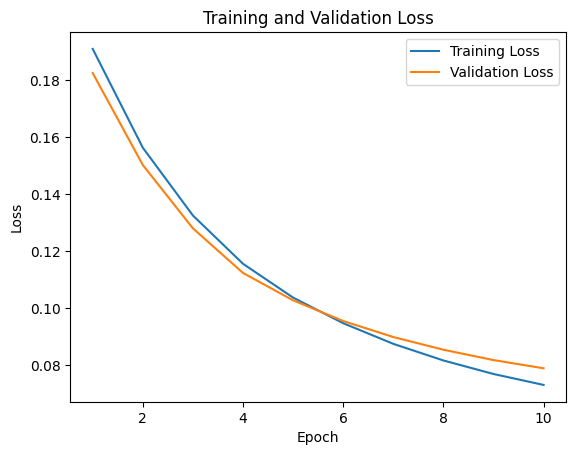

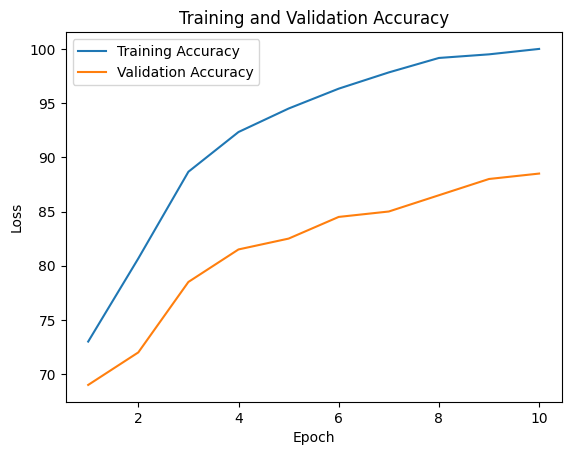

In [302]:
plt.plot(range(1, awc_num_epochs + 1), awc_train_losses, label='Training Loss')
plt.plot(range(1, awc_num_epochs + 1), awc_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(range(1, awc_num_epochs + 1), awc_train_accuracies, label='Training Accuracy')
plt.plot(range(1, awc_num_epochs + 1), awc_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### **End of Training: Save Best Model and Latent Represenatations**

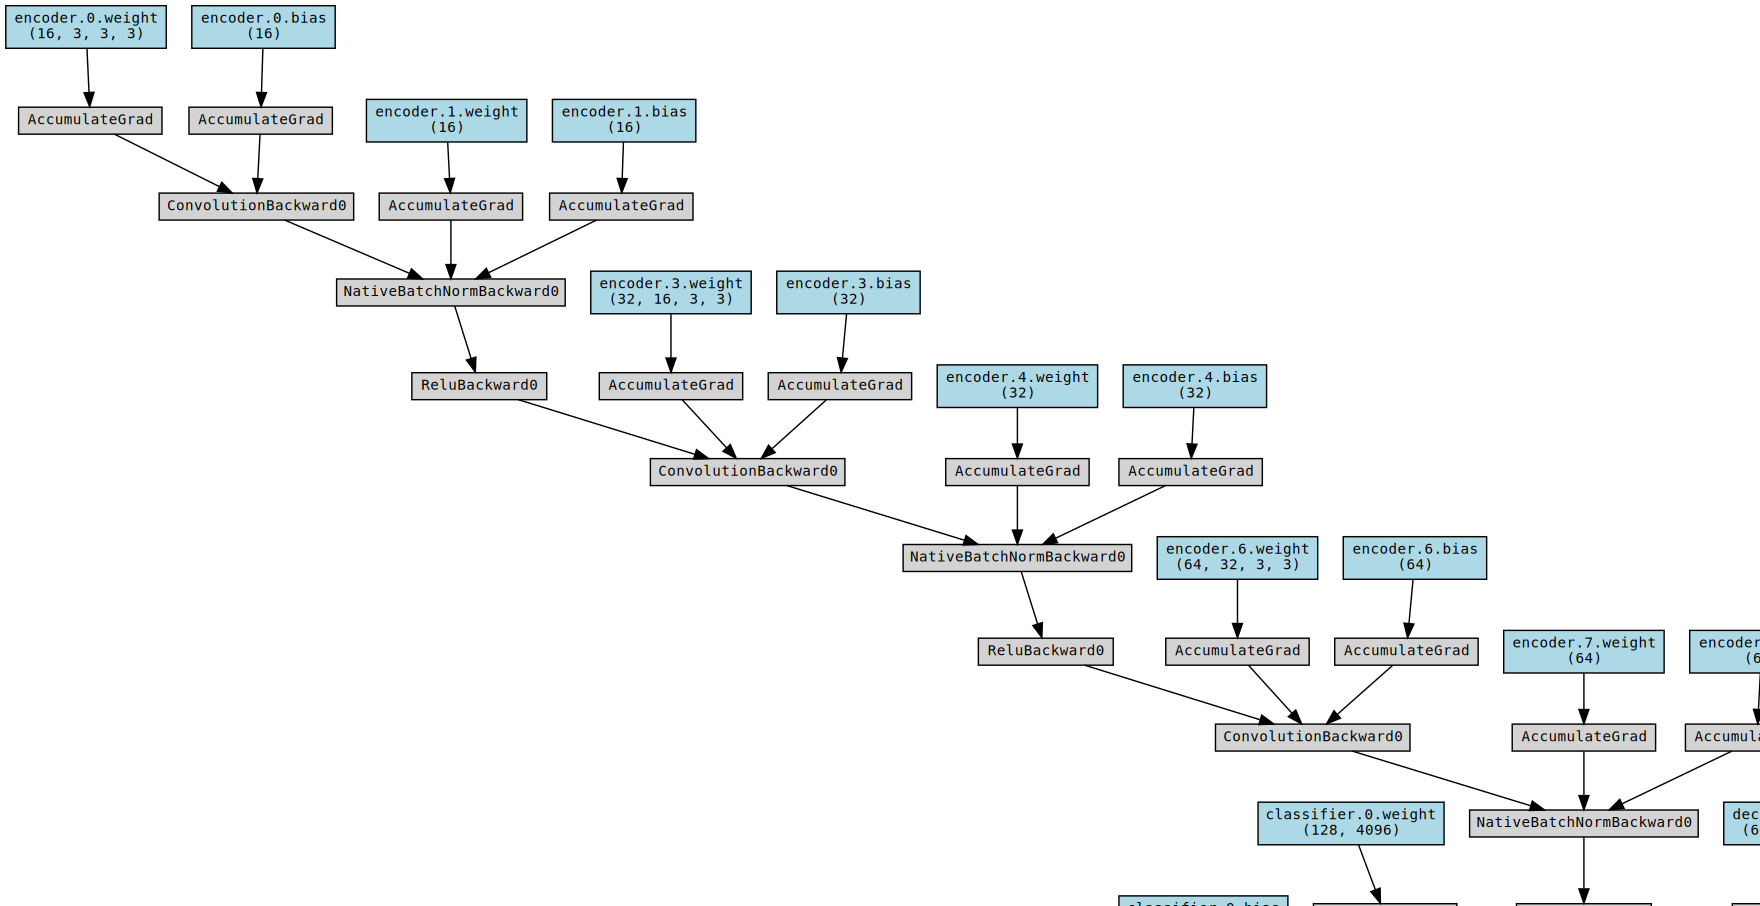

In [304]:
from torchviz import make_dot
dummy_input = torch.randn(1, 3, 64, 64)

output = awc_model(dummy_input)
make_dot(output, params=dict(awc_model.named_parameters()))
# dot = make_dot(output, params=dict(awc_model.named_parameters()))
# dot.format = 'svg'
# dot.render('autoencoder_classifier_architecture')

In [305]:
def save_model_weights(model, filepath):
    torch.save(model.state_dict(), filepath)

def save_latent_representations(model, dataset, filepath):
    model.eval()
    latent_reps = []
    with torch.no_grad():
        for t in dataset:
            images = transforms.ToTensor()(t['image'])
            latent_rep = model.encoder(images.unsqueeze(0))
            latent_reps.append(latent_rep.squeeze().numpy())
    np.save(filepath, np.array(latent_reps))

save_model_weights(awc_model, 'autoencoder_classifier_weights.pth')
save_latent_representations(awc_model, train_set, 'awc_train_latent_reps.npy')
save_latent_representations(awc_model, val_set, 'awc_val_latent_reps.npy')
save_latent_representations(awc_model, test_set, 'awc_test_latent_reps.npy')

In [306]:
from google.colab import drive
drive.mount('/content/drive')
import shutil
runtime_files = ['autoencoder_classifier_architecture.svg','autoencoder_classifier_weights.pth', 'awc_train_latent_reps.npy', 'awc_val_latent_reps.npy', 'awc_test_latent_reps.npy']
drive_dir = '/content/drive/My Drive/Winter-2024/Deep-Learning'
for file in runtime_files:
    shutil.copy(file, drive_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [307]:
import torch
from torchvision import transforms

def test_autoencoder_with_classification(model, test_set,lambda_val):
    reconstruction_criterion = nn.MSELoss()
    classification_criterion = nn.CrossEntropyLoss()

    # Switch model to evaluation mode
    model.eval()

    test_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for sample in test_set:
            images = transforms.ToTensor()(sample['image']).unsqueeze(0)
            labels = torch.tensor([sample['label']])

            reconstructed_images, class_logits = model(images)
            reconstruction_loss = reconstruction_criterion(reconstructed_images, images)
            classification_loss = classification_criterion(class_logits, labels)

            loss = lambda_val * reconstruction_loss + (1 - lambda_val) * classification_loss
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted_labels = torch.max(class_logits, 1)
            correct_preds += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    avg_test_loss = test_loss / len(test_set)
    test_accuracy = 100 * correct_preds / total_samples

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# **ASSIGNMENT: HW2 AUTOENCODERS - TEST**

## **Autoencoder - Test**

In [309]:
ae_model.eval()
criterion = nn.MSELoss()
running_test_loss = 0.0
with torch.no_grad():
    for t in test_set:
        images = transforms.ToTensor()(t['image'])
        outputs = ae_model(images)
        loss = criterion(outputs, images)
        running_test_loss += loss.item() * images.size(0)
test_loss = running_test_loss / len(test_set)

print(f'Final average error on the test set: {test_loss:.4f}')

Final average error on the test set: 0.0067


## **Autoencode with Classification - Test**

In [308]:
test_autoencoder_with_classification(awc_model, test_set, lambda_val)

Test Loss: 0.0926, Test Accuracy: 85.00%


## **ASSIGNMENT: HW2 AUTOENCODERS - QUESTIONS**

## **Question 1: Implement and train your autoencoder on the subset of the Emoji dataset that you selected and augmented**


### **a. describe your dataset and the steps that you used to create it**

The dataset consists of images of emojis with associated text descriptions.

To create the dataset, we used the Huggingface Emoji dataset, which provides a collection of emoji images and their corresponding descriptions. We filtered the dataset to select a subset based on specific text descriptions such as "face," "vampire," "elf," "mage," etc.

We divided this subset into training, validation, and test sets using a 60/20/20 ratio. Data augmentation techniques such as rotation, flipping, and resizing were applied to increase the diversity of the dataset.

Finally, we resized the images to a resolution of 64x64x3 to reduce computational complexity.

### **b. provide a summary of your architecture**

The autoencoder architecture consists of an encoder and a decoder, each composed of several convolutional layers. The purpose of the autoencoder is to learn a compressed representation of the input data in the latent space and then reconstruct the original input from this compressed representation.

**Encoder:**
1.   The encoder takes the input image with 3 channels (for RGB) and applies a series of convolutional layers to progressively reduce the spatial dimensions of the input while increasing the depth.
2.   The first convolutional layer has 3 input channels (RGB) and produces 16 output channels using a kernel size of 3x3, a stride of 2, and padding of 1. This operation effectively downsamples the input image by a factor of 2 in each spatial dimension.
3.   Subsequent convolutional layers follow a similar pattern, increasing the number of output channels while maintaining the downsampling operation. This hierarchical feature extraction process captures increasingly abstract features of the input image with the final layer at 32.

**Decoder:**


1.   The decoder aims to reconstruct the original input image from the compressed representation learned by the encoder. It consists of transposed convolutional layers, also known as "deconvolution" or "upsampling" layers, which perform the opposite operation of convolutional layers by increasing the spatial dimensions while decreasing the depth.
2.   The first transposed convolutional layer takes the encoded representation with 32 channels and applies a transposed convolution operation to upsample it to a larger spatial size.
3.   Subsequent transposed convolutional layers continue to upsample the feature maps until the final output layer, which has 3 channels corresponding to the RGB channels of the reconstructed image.
4.   The output of the final layer is passed through a sigmoid activation function, squashing the pixel values between 0 and 1 to produce a valid image reconstruction.

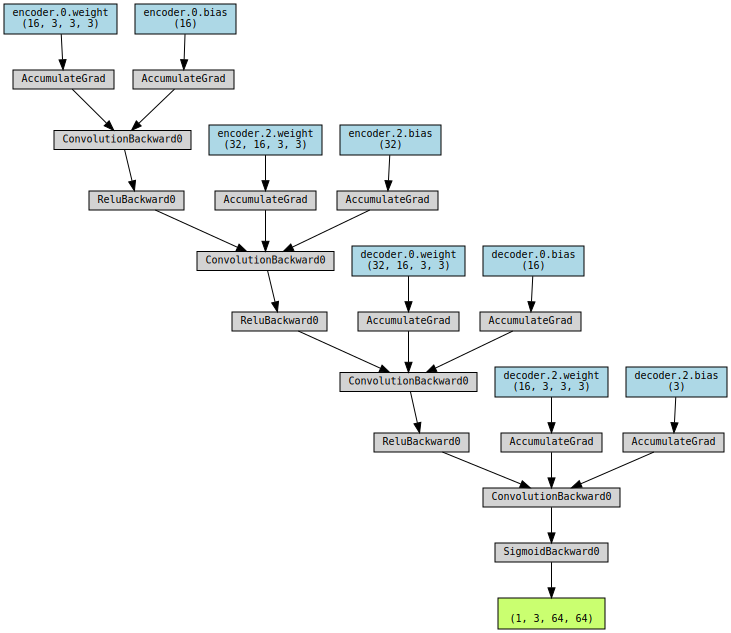

In [244]:
from torchviz import make_dot
dummy_input = torch.randn(1, 3, 64, 64)

output = ae_model(dummy_input)
make_dot(output, params=dict(ae_model.named_parameters()))
# dot = make_dot(output, params=dict(ae_model.named_parameters()))
# dot.format = 'svg'
# dot.render('autoencoder_architecture')

### **c. discuss and explain your design choices**



*   **Convolutional Layers**: We chose convolutional layers for both the encoder and decoder to effectively capture spatial relationships in images.
*   **ReLU Activation**: ReLU activation functions were selected for their simplicity and effectiveness in introducing non-linearity to the network.
*   **Convolutional and Transposed Convolutional Layers**: Regular convolutional layers downsample input images in the encoder, while transposed convolutional layers upsample features in the decoder.
*   **Latent Space Dimensionality**: A latent space dimensionality of 32 was chosen to balance the level of compression and model complexity.
*   **Output Activation**: Sigmoid activation in the output layer ensures output images conform to a valid pixel value range.
*   **Model Complexity and Efficiency**: The architecture strikes a balance between model complexity and computational efficiency, optimizing performance while remaining tractable for training and inference.

### **d. list hyper-parameters used in the model**



*   **Learning Rate (lr)**: 0.001.
*   **Number of Epochs (num_epochs)**: 35 epochs.
*   **Latent Size**: 32.
*   **Regularization weight_decay**: 1e-5

### **e. plot learning curves for training and validation loss as a function of training epochs**

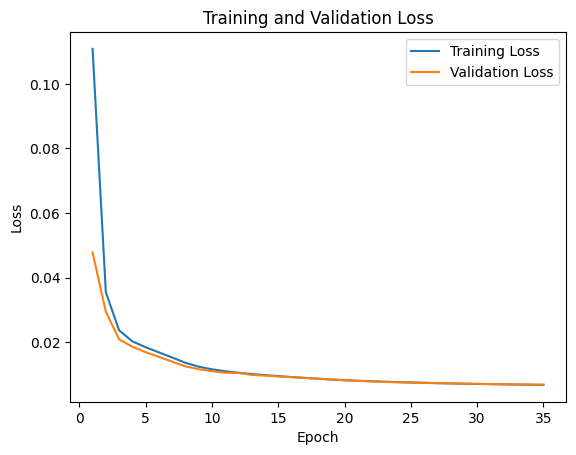

In [311]:
import matplotlib.pyplot as plt

plt.plot(range(1, ae_num_epochs + 1), ae_train_losses, label='Training Loss')
plt.plot(range(1, ae_num_epochs + 1), ae_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### **f. provide the final average error of your autoencoder on your test set**

In [295]:
ae_model.eval()
criterion = nn.MSELoss()
running_test_loss = 0.0
with torch.no_grad():
    for t in test_set:
        images = transforms.ToTensor()(t['image'])
        outputs = ae_model(images)
        loss = criterion(outputs, images)
        running_test_loss += loss.item() * images.size(0)
test_loss = running_test_loss / len(test_set)

print(f'Final average error on the test set: {test_loss:.4f}')

Final average error on the test set: 0.0067


### **g. discuss any decisions or observations that you find relevant.**

1. Batch Normalization was not performed as it increased model complexity and caused overfitting.
2. While the latent size was experimented across 32, 64, 128 and 256, it was found that the simpler the architecture of 32, the better the model performance.
3. Unclear why the image data format changes in different runs. In the original tests the image format was in Tensor and then later caused an error and was found to be in PIL. No clear reason noted, code was included to transform from PIL to Tensor per last run.

## **Question 2:**

*(5.0 points)*

Separate your dataset into two or more classes using Emoji descriptions and assign labels. Repeat Step 1 adding image classification as an auxiliary task to MSE with a λ of your choosing.

You can choose any classification technique.



*   describe how you separated your dataset into classes
*   describe your classification technique and hyper-parameters
*   plot learning curves for training and validation loss for MSE and classification accuracy
*   discuss how incorporating classification as an auxiliary tasks impacts the performance of your autoencoder
*   speculate why performance changed and recommend (but do not implement) an experiment to confirm or reject your speculation.

### **a.   Describe how you separated your dataset into classes**


For separating the dataset into classes, we utilized the descriptions of emojis to categorize them into two classes: "**fictional**" (1) and "**non-fictional**" (0).

Emojis associated with descriptions like "*vampire*", "*elf*", "*mage*", etc., were labeled as "fictional", while those lacking such descriptors were categorized as "non-fictional".

This approach allowed us to create distinct class labels based on semantic information present in the emoji descriptions, facilitating the classification task.

In [296]:
print("Subset example:", labeled_subset[25])
print("Subset example:", labeled_subset[100])

Subset example: {'text': 'cat face with tears of joy', 'label': 0, 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F0C93106D40>}
Subset example: {'text': 'man elf dark skin tone', 'label': 1, 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7F0C931067A0>}


### **b. Describe your classification technique and hyper-parameters**

The classification technique is integrated into an autoencoder architecture. The model's encoder compresses the input image into a lower-dimensional representation, which is then used for two tasks: reconstructing the original image (decoder output) and classifying the image (classification head output). The classification head consists of fully connected layers that take the flattened encoded features as input and output logits for the defined classes.

The primary hyper-parameters are:

1. Learning rate (lr): 0.00001
2. Weight decay: 1e-5, used for regularization to prevent overfitting.
3. Number of epochs (num_epochs): 10.
4. Lambda value (lambda_val): 0.9, balancing the reconstruction loss (MSE) and the classification loss (Cross-Entropy Loss).

### **c. plot learning curves for training and validation loss for MSE and classification accuracy**

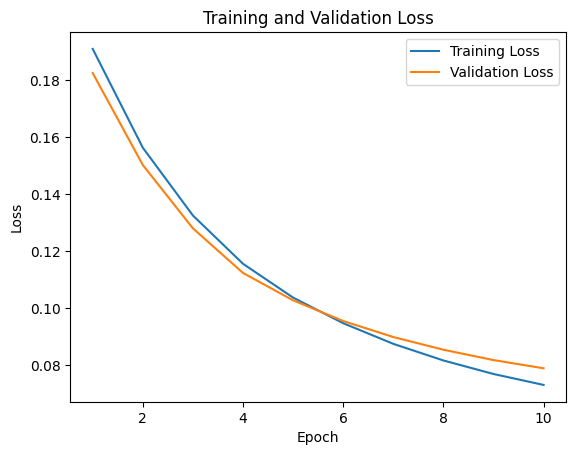

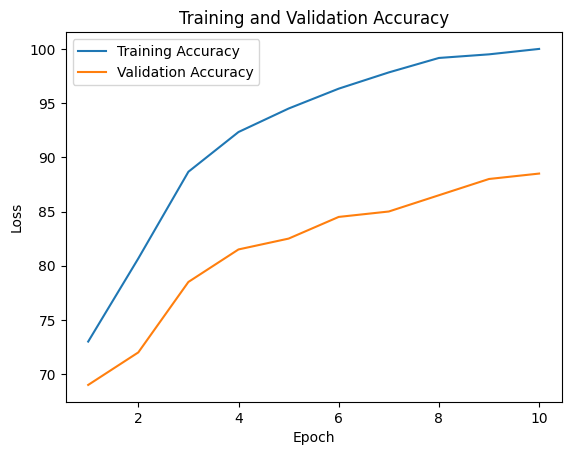

In [310]:
plt.plot(range(1, awc_num_epochs + 1), awc_train_losses, label='Training Loss')
plt.plot(range(1, awc_num_epochs + 1), awc_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(range(1, awc_num_epochs + 1), awc_train_accuracies, label='Training Accuracy')
plt.plot(range(1, awc_num_epochs + 1), awc_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### **d. discuss how incorporating classification as an auxiliary tasks impacts the performance of your autoencoder**

**Basic Autoencoder Performance**:
1. Latent Space: The original autoencoder had a latent space of 32, which is a compact representation of the input data.
2. Training Dynamics: The training and validation loss steadily decreased over 35 epochs, indicating that the model was learning to reconstruct the input data effectively. The smooth and consistent reduction in loss suggests that the model was fitting well without signs of overfitting or underfitting.
3. Hyperparameters: The model used weight decay for regularization, helping prevent overfitting to the training data.

**Autoencoder with Classification**:
1. Latent Space and Architecture Enhancements: The enhanced autoencoder had a larger latent space of 64 and included batch normalization. The larger latent space can potentially capture more detailed features of the input data, while batch normalization helps stabilize training and improve convergence speed.
2. Training Dynamics: The addition of the classification task, with a significant focus on classification loss (lambda value of 0.9), shows a different pattern. The training and validation losses are higher initially but decrease rapidly. Moreover, the training and validation accuracies increase to 100% and 88.5%, respectively, over just 15 epochs. This rapid improvement suggests that the model is not only learning to reconstruct the inputs but also gaining a meaningful understanding of the data that aids classification.
3. Hyperparameters Adjustments: The learning rate is significantly lower (0.00001), which was necessary to balance the dual tasks of reconstruction and classification without causing instability in training.

**Impact of Incorporation of Classification Task**
1. Improved Feature Representation: The auxiliary classification task forces the autoencoder to learn more discriminative features in the latent space, which are not only good for reconstruction but also useful for classification. This leads to a more robust and versatile model.
2. Faster Convergence: The model with the classification task converges faster (in fewer epochs) compared to the basic autoencoder. This could be due to the model learning more generalizable features that aid in both reconstruction and classification.



### **e. speculate why performance changed and recommend (but do not implement) an experiment to confirm or reject your speculation.**

***Why Performance Changed***: The improved performance in the autoencoder with classification can be attributed to the model learning more meaningful and discriminative features due to the dual objectives. Batch normalization likely contributed to more stable and faster training. The larger latent space might have allowed the model to capture a richer set of features necessary for accurate classification.

***Further Experimentation***: To confirm these speculations, one could conduct further experiments by varying the lambda value to see its effect on the balance between reconstruction and classification performance. Additionally, experimenting with different sizes of the latent space and comparing models with and without batch normalization could help isolate the impact of each architectural decision.